# FLUX.2 Klein Workshop: From API to LoRA Customization

**Black Forest Labs x NVIDIA**

This notebook demonstrates FLUX.2 Klein capabilities and shows how LoRA fine-tuning enables customization beyond what the base model can do.

## What We'll Cover

1. **API Quickstart** — Text-to-image generation with Klein 9B
2. **Exploring Limitations** — Prompts the model struggles with
3. **LoRA Training** — Fine-tuning Klein for custom concepts
4. **Results** — What becomes possible with customization

![Realism](https://cdn.sanity.io/images/2gpum2i6/production/41055678178f6fe75ca618b854b195e48dfc55ed-2127x1400.jpg)

![Editing](https://cdn.sanity.io/images/2gpum2i6/production/86adb8bf9ea077f3aebe392af1077f0337ed9c48-4544x2805.jpg)
---

## Prerequisites

- **For API demos**: BFL API key from [dashboard.bfl.ai](https://dashboard.bfl.ai/get-started)

---

## Setup

In [16]:
# Install dependencies (uncomment if needed)
# !pip install requests matplotlib pillow torch diffusers transformers accelerate peft bitsandbytes fal-client 

import os
import time
import base64
from io import BytesIO
from pathlib import Path
from typing import Optional, List

import requests
from PIL import Image
import matplotlib.pyplot as plt

from dotenv import load_dotenv

load_dotenv()

# Display settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.grid'] = False

print("Setup complete!")

Setup complete!


In [17]:
# Configuration
BFL_API_KEY = os.environ.get("BFL_API_KEY")

API_BASE = "https://api.bfl.ai/v1"

OUTPUT_DIR = Path("./outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

def get_headers():
    """Get headers for BFL API requests."""
    return {
        "accept": "application/json",
        "x-key": BFL_API_KEY,
        "Content-Type": "application/json",
    }

---

# Part 1: FLUX.2 Klein 9B via API

Klein 9B is our best Klein model — sub-second generation with excellent prompt following.

| Model | License | Speed | VRAM (local) |
|-------|---------|-------|--------------|
| **Klein 9B** | FLUX Non-Commercial | Sub-second | ~24GB |
| **Klein 4B** | Apache 2.0 | Sub-second | ~13GB |

## 1.1 Helper Functions

In [18]:
def submit_request(endpoint: str, payload: dict) -> dict:
    """Submit a request to the BFL API."""
    url = f"{API_BASE}/{endpoint}"
    response = requests.post(url, headers=get_headers(), json=payload)
    response.raise_for_status()
    return response.json()


def poll_result(polling_url: str, max_wait: int = 120) -> dict:
    """Poll for the result of an async request."""
    start = time.time()
    
    while time.time() - start < max_wait:
        response = requests.get(polling_url, headers={"accept": "application/json", "x-key": BFL_API_KEY})
        result = response.json()
        
        status = result.get("status")
        if status == "Ready":
            return result["result"]
        elif status == "Failed":
            raise Exception(f"Generation failed: {result.get('error', 'Unknown error')}")
        
        time.sleep(0.5)
    
    raise TimeoutError(f"Request timed out after {max_wait}s")


def generate_image(endpoint: str, payload: dict, show: bool = True) -> Image.Image:
    """Generate an image and optionally display it."""
    print(f"Submitting request to {endpoint}...")
    response = submit_request(endpoint, payload)
    
    request_id = response["id"]
    polling_url = response["polling_url"]
    cost = response.get("cost", "N/A")
    
    print(f"Request ID: {request_id}")
    print(f"Cost: {cost} credits")
    print("Waiting for result...")
    
    result = poll_result(polling_url)
    
    image_url = result["sample"]
    image_response = requests.get(image_url)
    image = Image.open(BytesIO(image_response.content))
    
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        prompt_preview = payload.get('prompt', '')[:80]
        plt.title(f"{prompt_preview}...", fontsize=10, wrap=True)
        plt.tight_layout()
        plt.show()
    
    return image


def display_images_grid(images: List[Image.Image], titles: List[str] = None, cols: int = 3):
    """Display multiple images in a grid."""
    n = len(images)
    rows = (n + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten() if n > 1 else [axes]
    
    for idx, (ax, img) in enumerate(zip(axes, images)):
        ax.imshow(img)
        ax.axis('off')
        if titles and idx < len(titles):
            ax.set_title(titles[idx], fontsize=10)
    
    for ax in axes[n:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## 1.2 Text-to-Image with Klein 9B

Let's see what Klein 9B can do out of the box. Remember: **narrative prose, not keywords**.

In [ ]:
# A well-crafted narrative prompt
prompt = """
A car driving through a country road, on the other side of the river is a large city in the background, colorful, vibrant glow
""".strip()

payload = {
    "prompt": prompt,
    "width": 1024,
    "height": 1440,
    "seed": 42
}

image = generate_image("flux-2-klein-9b-private", payload)

In [ ]:
# More examples showcasing Klein 9B's strengths

# Architectural photography
arch_prompt = """
A view of a city skyline seen through a window with silhouettes of people in the foreground. 
The One World Trade Center tower rises prominently in the center against a clear blue sky. 
The scene has a soft, muted color palette, giving it a serene and contemplative atmosphere.
""".strip()

# Product photography
product_prompt = """
A basket with a stylish design and neutral colors, showing fruits and vegetables, 
realistic product illustration, kitchen supply store setting, clean and practical, natural lighting
""".strip()

print("Generating architectural shot...")
arch_image = generate_image("flux-2-klein-9b-private", {"prompt": arch_prompt, "width": 1024, "height": 1440, "seed": 100}, show=True)

print("\nGenerating product shot...")
product_image = generate_image("flux-2-klein-9b-private", {"prompt": product_prompt, "width": 1024, "height": 1440, "seed": 200}, show=True)

## 1.3 Hex Color Matching

FLUX.2 supports precise color specification via hex codes — great for brand consistency.

In [ ]:
# Brand colors via hex codes
brand_prompt = """
A modern living room interior. The accent wall is painted in color #003049.
A plush velvet sofa in color #D62828 sits against it. 
Throw pillows in color #F77F00 and color #FCBF49 add contrast. 
Natural daylight creates a warm, inviting atmosphere. 
Interior design magazine style photography.
""".strip()

payload = {
    "prompt": brand_prompt,
    "width": 1440,
    "height": 1024,
    "seed": 123
}

color_image = generate_image("flux-2-klein-9b-private", payload)

---

# Part 2: Image Editing with Klein

**FLUX.2 Klein is the best open-source image editing model in the world.**

It excels at understanding context, preserving what matters, and making precise transformations. Whether you're swapping backgrounds, changing styles, or composing multiple references — Klein delivers.

### Key Principle
Reference images carry the visual details. Your prompt describes *what should change*, not what the image looks like.

### Edit Types
| Type | Description | Example Prompt |
|------|-------------|----------------|
| **Background swap** | Change the environment | "Place her in a coffee shop" |
| **Style transfer** | Apply a new visual style | "Turn into a watercolor painting" |
| **Object replacement** | Swap specific elements | "Replace the bike with a horse" |
| **Element addition** | Add new objects | "Add a cat sleeping on the chair" |
| **Attribute change** | Modify properties | "Change the dress from blue to red" |

In [ ]:
# Helper for image editing
def image_to_base64(image: Image.Image) -> str:
    """Convert a PIL Image to base64 string."""
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

## Examples

### Motorcycle input
![Input Image](https://cdn.sanity.io/images/2gpum2i6/production/59fdd6b45c1d2d4180390ae98380a9425ce8bd99-765x956.jpg)

In [ ]:
generate_image(
    "flux-2-klein-9b-private",
    {
        "prompt": "Replace the bike with a rearing black horse",
        "input_image": "https://cdn.sanity.io/images/2gpum2i6/production/59fdd6b45c1d2d4180390ae98380a9425ce8bd99-765x956.jpg",
        "width": 1024,
        "height": 1024,
        "seed": 42},
    show=False
)

### Edit style
![Input Image](https://cdn.sanity.io/images/2gpum2i6/production/00f3de86b945fb15ebf80fedb73bf25613a6cc63-627x1115.jpg)

In [ ]:
generate_image(
    "flux-2-klein-9b-private",
    {
        "prompt": "Reskin this into a realistic mountain vista. The building is made of concrete",
        "input_image": "https://cdn.sanity.io/images/2gpum2i6/production/00f3de86b945fb15ebf80fedb73bf25613a6cc63-627x1115.jpg",
        "width": 1024,
        "height": 1024,
        "seed": 42},
    show=False
)

### Failures 

In some cases, the models might not give you the results you expect. This is where FLUX.2 [klein] Base models will shine, they are very finetunable 


For example, let's try to create a Game Sprit sheets based on this input image: 
![input_image](https://images.pexels.com/photos/13575248/pexels-photo-13575248.jpeg)


### Without a LoRA with FLUX.2 [klein] 9B

In [ ]:
generate_image(
    "flux-2-klein-9b-private",
    {
        "prompt": "Create a 2x2 sprite sheet with 4 camera angles used for a video game of the car used as reference",
        "input_image": "https://images.pexels.com/photos/13575248/pexels-photo-13575248.jpeg",
        "width": 1024,
        "height": 1024,
        "seed": 42},
    show=False
)

---

# Part 3: The Power of LoRA Fine-Tuning

Klein is excellent, specially for its size, but some tasks require teaching the model new concepts. **LoRA (Low-Rank Adaptation)** lets you do this. .

Let's see a real example: **generating game sprite sheets**.

### The Challenge
Creating consistent multi-view sprite sheets is hard for base models — they don't understand the specific layout and angle conventions game developers need.

### The Solution
The [Spritesheet LoRA](https://huggingface.co/fal/flux-2-klein-4b-spritesheet-lora) was trained to generate professional 2×2 sprite sheets with 4 camera angles:
- **Top-Left**: Isometric 3/4 view (facing ↘)
- **Top-Right**: Isometric 3/4 view (facing ↙)  
- **Bottom-Left**: Side profile (facing ←)
- **Bottom-Right**: Top-down bird's eye view


![biplane.png](https://huggingface.co/fal/flux-2-klein-4b-spritesheet-lora/resolve/main/examples/biplane_output.png)

![sport_cars.png](https://huggingface.co/fal/flux-2-klein-4b-spritesheet-lora/resolve/main/examples/sports_car_output.png)

### Dataset

48 curated sprite sheet pairs (from 120 generated, manually validated)

In [ ]:
# First, let's see what the BASE MODEL produces when we ask for a sprite sheet
# Without the LoRA, it doesn't understand the specific layout we need

generate_image(
    "flux-2-klein-9b-private",
    {
        "prompt": "Create a 2x2 sprite sheet with 4 camera angles used for a video game of the car used as reference",
        "input_image": "https://images.pexels.com/photos/13575248/pexels-photo-13575248.jpeg",
        "width": 1024,
        "height": 1024,
        "seed": 42},
    show=True
)

print("BASE MODEL: Attempting to generate a sprite sheet...")
print("The model doesn't know what a '2x2 sprite sheet' layout means.\n")


In [ ]:
import fal_client

def on_queue_update(update):
    if isinstance(update, fal_client.InProgress):
        for log in update.logs:
           print(log["message"])

# Example with a plane

result = fal_client.subscribe(
    "fal-ai/flux-2/klein/4b/base/edit/lora",
    arguments={
        "prompt": "2x2 sprite sheet",
        "model_name": None,
        "loras": [{
            "path": "https://v3b.fal.media/files/b/0a8afd73/S-6Mv13UtHX8zoItgp0AY_pytorch_lora_weights.safetensors",
            "scale": 1.1
        }],
        "embeddings": [],
        "image_urls": ["https://huggingface.co/fal/flux-2-klein-4b-spritesheet-lora/resolve/main/examples/biplane_input.png"],
        "image_size": "square_hd"
    },
    with_logs=True,
    on_queue_update=on_queue_update,
)
print(result)

In [ ]:
# Example with a car

result = fal_client.subscribe(
    "fal-ai/flux-2/klein/4b/base/edit/lora",
    arguments={
        "prompt": "2x2 sprite sheet",
        "model_name": None,
        "loras": [{
            "path": "https://v3b.fal.media/files/b/0a8afd73/S-6Mv13UtHX8zoItgp0AY_pytorch_lora_weights.safetensors",
            "scale": 1.1
        }],
        "embeddings": [],
        "image_urls": ["https://huggingface.co/fal/flux-2-klein-4b-spritesheet-lora/resolve/main/examples/sports_car_input.png"],
        "image_size": "square_hd"
    },
    with_logs=True,
    on_queue_update=on_queue_update,
)
print(result)

### Why LoRA?

| Aspect | Details |
|--------|---------|
| **Size** | ~50-150MB adapter file |
| **Training** | Minutes to hours, not days |
| **Composable** | Stack multiple LoRAs together |
| **Shareable** | Easy to distribute on HuggingFace |

**Use cases**: Game assets, consistent characters, brand products, artistic styles, domain-specific outputs.

Find more LoRAs at [huggingface.co/models?other=flux](https://huggingface.co/models?search=flux%20lora)

## We will publish LoRAs guidance soon 

Some examples of what is possible with LoRAs

**Left - Base Model**

**Right - LoRA**
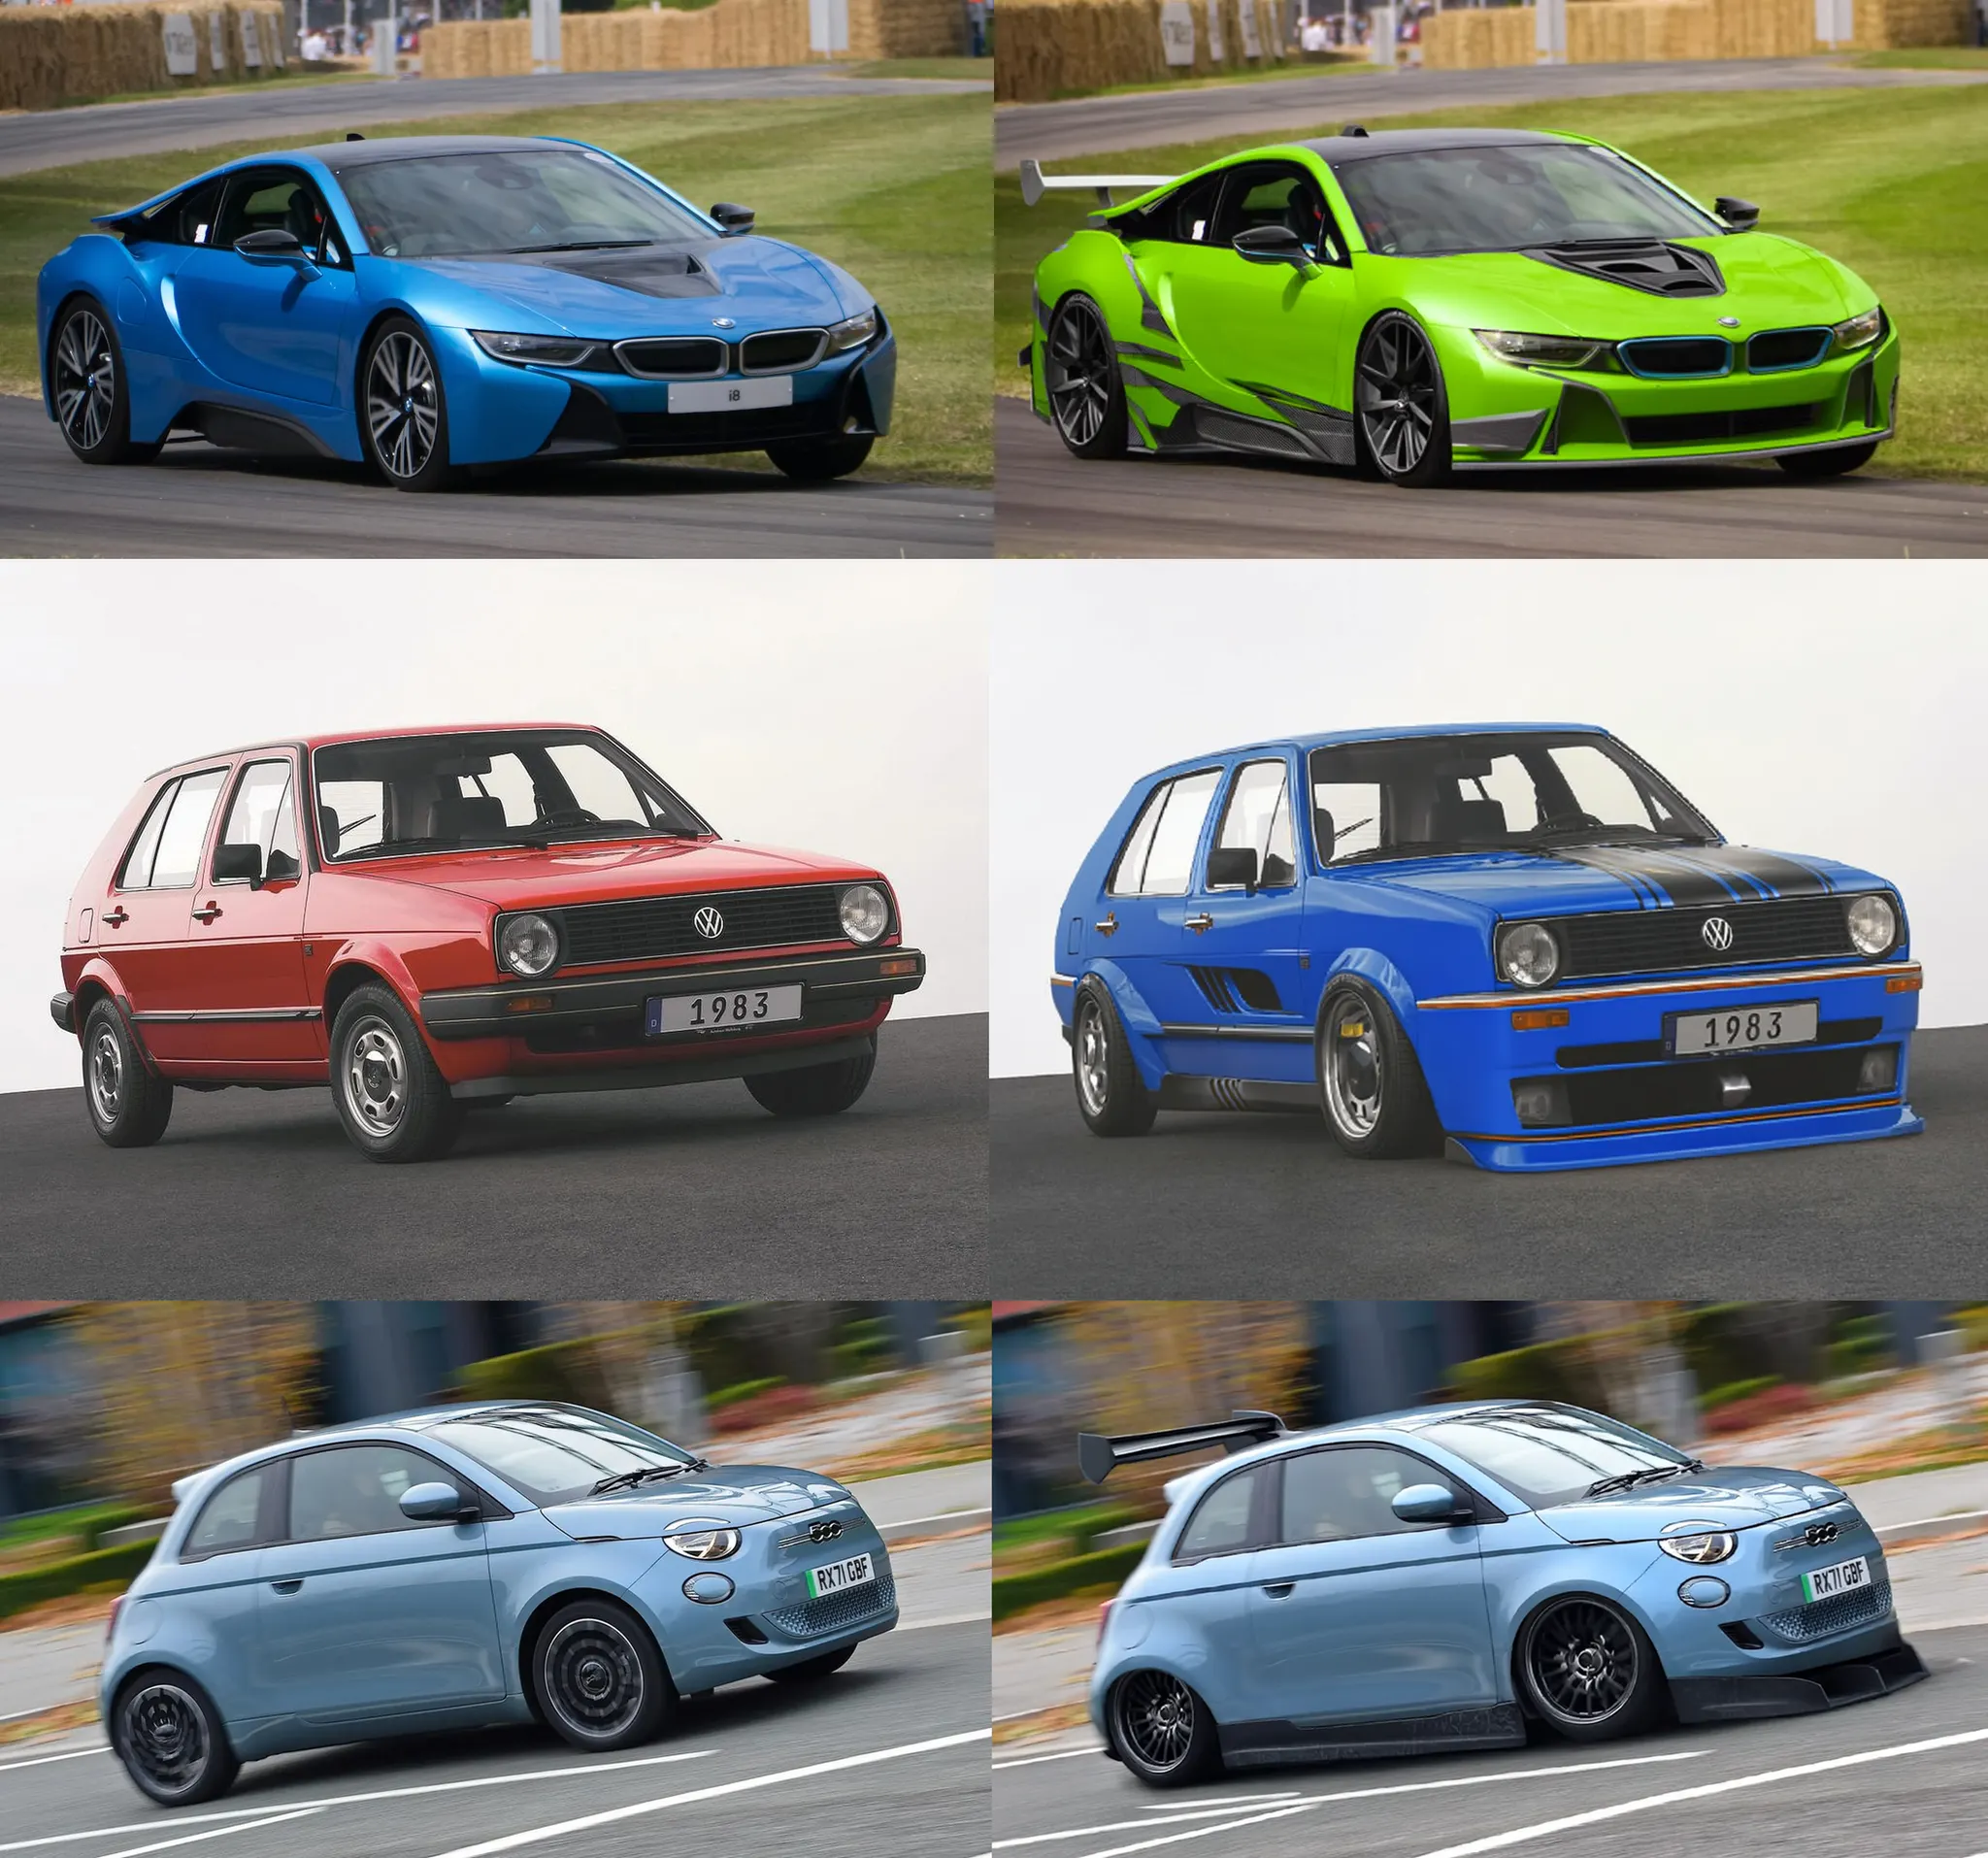


---

# Summary

### FLUX.2 Klein
- **Klein 9B** — Best quality in the Klein family, sub-second API inference
- **Klein 4B** — Apache 2.0 license, smallest footprint
- **Base models** — Undistilled variants for fine-tuning

### When to Use LoRA
- **Consistent characters** — Faces, personas, avatars
- **Brand assets** — Products, logos, visual identity
- **Custom styles** — Artistic techniques, aesthetics
- **Domain adaptation** — Specialized content types

---

## Resources

### API & Documentation
- **API Getting Started**: [Getting Started](https://dashboard.bfl.ai/get-started)
- **Docs**: [docs.bfl.ai](https://docs.bfl.ai)
- **Playground**: [playground.bfl.ai](https://playground.bfl.ai)

### Models & Training
- **Hugging Face**: [huggingface.co/black-forest-labs](https://huggingface.co/black-forest-labs)
- **Klein 9B Base**: `black-forest-labs/FLUX.2-klein-9B-base`
- **Klein 4B Base**: `black-forest-labs/FLUX.2-klein-4B-base`

### Community
- **GitHub**: [github.com/black-forest-labs](https://github.com/black-forest-labs)

---

*Workshop by Black Forest Labs x NVIDIA*